In [1]:
# !pip install easyocr
# !pip install fuzzywuzzy
# !pip install transformers accelerate --upgrade


In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
#from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter1d
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import easyocr

## Medecine dataset

In [ ]:
# Load the XLS file
df = pd.read_excel('/content/med.xls')

# Keep only the 'Nom' column
df = df[['Nom']]

# Keep only the first word in each 'Nom'
df['Nom'] = df['Nom'].astype(str).str.split().str[0]

# Remove duplicate values
df = df.drop_duplicates()

# Save the cleaned data to a new Excel file
df.to_excel('cleaned_file.xlsx', index=False)

# Print a preview
print(df.head())

# Load the cleaned names once
df = pd.read_excel('cleaned_file.xlsx')
name_list = df['Nom'].dropna().astype(str).tolist()


               Nom
0   5-FLUOROURACIL
1  5-FLUOROURACILE
3       ABBOTICINE
4           ABEVMY
6        ABILICARE


## image preprocessing

<function matplotlib.pyplot.show(close=None, block=None)>

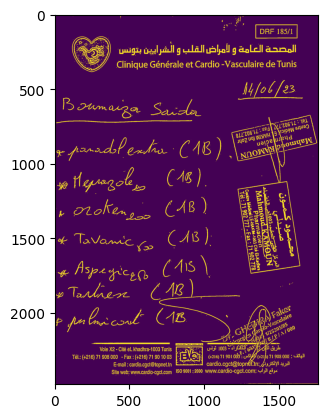

In [ ]:
image_file = "/content/0729--9550572--20230705_page_2.jpg"
#image_file = "predictions/nom_et_prenom_de_adherent_5.jpg"
img = cv2.imread(image_file)
# Load and preprocess the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
processed_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)

plt.imshow(processed_img)
plt.show

In [ ]:
# Create the output directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
# Initialize EasyOCR for detection
reader = easyocr.Reader(['fr'], gpu=False)

# Detect bounding boxes
results = reader.readtext(
    processed_img,
    detail=1,  # Get bounding box details
    paragraph=False,
    ycenter_ths=0.3,
    height_ths=2,
    min_size=20,  # Minimum size of detected text
    mag_ratio=1.5  # Increase resolution for better detection
)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Load the trained model
cnn_classification_model = tf.keras.models.load_model("text_classification_model.h5")

# Function to preprocess an image
def preprocess_image(img, IMG_HEIGHT=256, IMG_WIDTH=128):
    # Check if the image is None or empty
    if img is None or img.size == 0:
        raise ValueError("Image not loaded correctly or is empty.")

    # Resize the image to the target dimensions
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Normalize pixel values to [0, 1]
    img = img / 255.0

    # Add batch and channel dimensions: (1, 256, 128, 1)
    img = np.expand_dims(img, axis=(0, -1))  # Adds batch dimension and channel dimension

    return img

def interpret_prediction(img):
    prediction = cnn_classification_model.predict(img)
    # Interpret the prediction (sigmoid output: <0.5 is handwritten, >=0.5 is printed)
    label = "Handwritten" if prediction[0][0] < 0.5 else "Printed"
    confidence = 1 - prediction[0][0] if label == "Handwritten" else prediction[0][0]

    # Print the results
    print(f"Predicted class: {label} (Confidence: {confidence:.2f})")
    return label



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Process each detected (and merged) word
for idx, (bbox, text, prob) in enumerate(results):
    # Extract the bounding box coordinates
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # Crop the word from the image
    word_img = processed_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Debugging: Print word image size
    print(f"Word {idx+1} Crop Size: {word_img.shape}")

    # Ensure the cropped image has valid dimensions
    if word_img.shape[0] > 0 and word_img.shape[1] > 0:
        word_img_preprocessed = preprocess_image(word_img)
        label = interpret_prediction(word_img_preprocessed)

        # Save the word image if it's labeled as "Handwritten"
        if label == "Handwritten":
            output_path = os.path.join(output_dir, f"word_{idx+1}.png")
            cv2.imwrite(output_path, word_img)
            print(f"Saved word {idx+1} to {output_path} (Text: {text}, Confidence: {prob:.2f})")
    else:
        print(f"Word {idx+1} has invalid dimensions and will be skipped.")


Word 1 Crop Size: (55, 231)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Predicted class: Printed (Confidence: 1.00)
Word 2 Crop Size: (108, 1213)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted class: Printed (Confidence: 1.00)
Word 3 Crop Size: (88, 1227)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: Printed (Confidence: 1.00)
Word 4 Crop Size: (148, 391)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted class: Handwritten (Confidence: 0.99)
Saved word 4 to output/word_4.png (Text: h4LoLI2z, Confidence: 0.02)
Word 5 Crop Size: (110, 329)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: Handwritten (Confidence: 1.00)
Saved word 5 to output/word_5.png (Text: Baumn , Confidence: 0.05)
Word 6 Crop Size: (127, 358)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: Handwritten (Confidence: 1.00)
Saved word 6 to output/word_6.png (Text: Sasl_, Confidence: 0.25)
Word 7 Crop Size: (38, 62)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted class: Printed (Confidence: 1.00)
Word 8 Cro

In [ ]:
def match_word_to_names(word, name_list, threshold=60):
    matches = []
    for name in name_list:
        similarity = fuzz.ratio(word.lower(), name.lower())
        if similarity >= threshold:
            matches.append((name, similarity))
    return matches

In [ ]:
# Load TrOCR model and processor for French handwritten text
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Load line images from the "output" directory
output_dir = "output"
line_images = []
for filename in os.listdir(output_dir):
    if filename.startswith("word") and filename.endswith(".png"):
        img_path = os.path.join(output_dir, filename)
        line_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if line_img is not None:
            # Convert grayscale to RGB by duplicating the channel
            line_img_rgb = cv2.cvtColor(line_img, cv2.COLOR_GRAY2RGB)  # Shape: (height, width) -> (height, width, 3)
            line_images.append(line_img_rgb)

In [ ]:
# Function to check if text contains more than one non-letter character (excluding spaces)
def is_valid_text(text):
    # Count non-letter characters (excluding spaces)
    non_letter_count = len(re.findall(r'[^a-zA-Z\s]', text))  # Matches anything that's not a letter or space
    cleaned_text = re.sub(r'[^a-zA-Z]', '', text)  # Replace anything that's not a letter or space with ''
    return non_letter_count <= 1,cleaned_text  # Valid if there are 0 or 1 non-letter characters


Added text: Aspe (Valid)
Skipped text: B (Too many non-letter characters)
Skipped text: C (Too many non-letter characters)
Skipped text: B (Too many non-letter characters)
Skipped text: Cs (Too many non-letter characters)
Added text: house (Valid)
Added text: extra (Valid)
Skipped text: CB (Too many non-letter characters)
Skipped text: ft (Too many non-letter characters)
Added text: Sainctor (Valid)
Added text: Tantness (Valid)
Added text: Brum (Valid)
Skipped text: f (Too many non-letter characters)
Added text: Megazole (Valid)
Added text: ricers (Valid)
Skipped text: B (Too many non-letter characters)
Added text: ozoken (Valid)
Added text: TAVANC (Valid)


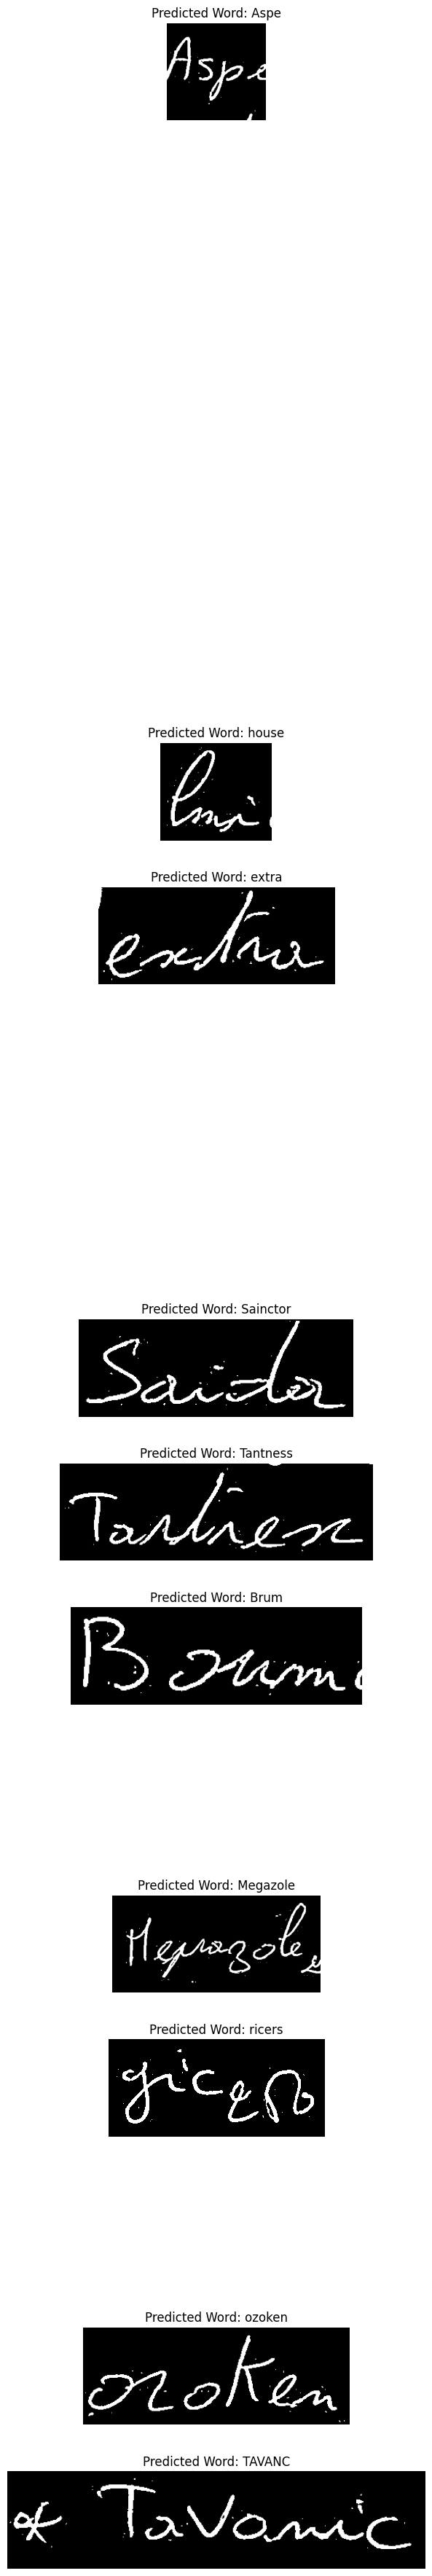

In [ ]:
plt.figure(figsize=(10, len(line_images) * 2))  # Adjust figure size based on number of lines
predicted_images_text=[]
for i, line_img in enumerate(line_images):
    # Convert to PIL Image for TrOCR
    pil_img = Image.fromarray(line_img, mode='RGB')

    # Preprocess and generate text
    pixel_values = processor(pil_img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    is_valid , text = is_valid_text(text)
    if is_valid_text and len(text)>2:
      predicted_images_text.append(text)
      print(f"Added text: {text} (Valid)")
      # Create subplot and show image
      plt.subplot(len(line_images), 1, i + 1)
      plt.imshow(line_img)
      plt.title(f"Predicted Word: {text}", fontsize=12)
      plt.axis('off')
    else:
        print(f"Skipped text: {text} (Too many non-letter characters)")


# Adjust layout with extra padding to prevent overlap
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
for pred in predicted_images_text:
    predict = match_word_to_names(pred,name_list, threshold=65)

    # Sort the matches by similarity (highest first)
    predict = sorted(predict, key=lambda x: x[1], reverse=True)

    # Prepare the message
    print(f"Matches for \033[1m{pred}\033[0m")
    if predict:
        for matched_name, similarity in predict:
            print(f"\033[1m'{matched_name}'\033[0m (Similarity: {similarity}%)")
    else:
        print(f"No match for {pred}")
    print("\n")


Matches for Aspe
'ASPEGIC' (Similarity: 73%)
'ASPIRINE' (Similarity: 67%)
'OSPEN' (Similarity: 67%)


Matches for house
No match for house


Matches for Megazole
'OMEPRAZOLE' (Similarity: 78%)
'MEPRAZOL' (Similarity: 75%)
'ECONAZOLE' (Similarity: 71%)
'MEGACE' (Similarity: 71%)
'OMEZOL' (Similarity: 71%)
'CEFAZOL' (Similarity: 67%)
'MEGACEF' (Similarity: 67%)
'METRONIDAZOLE' (Similarity: 67%)
'TEGOZOL' (Similarity: 67%)


Matches for TAVANC
'TAVANIC' (Similarity: 92%)
'TAVACET' (Similarity: 77%)
'VANCO' (Similarity: 73%)
'TRAVATAN' (Similarity: 71%)
'AVENOC' (Similarity: 67%)
'FOSAVANCE' (Similarity: 67%)


Matches for ozoken
'OROKEN' (Similarity: 83%)
'ZOLEN' (Similarity: 73%)


Matches for Brum
'BERCUM' (Similarity: 80%)
'BAUME' (Similarity: 67%)
'IBURHUME' (Similarity: 67%)


Matches for Sainctor
'VAINCOR' (Similarity: 80%)
'AFINITOR' (Similarity: 75%)
'SINOCORT' (Similarity: 75%)
'STATINOR' (Similarity: 75%)
'CINCOR' (Similarity: 71%)
'ATOR' (Similarity: 67%)
'GABINOR' (Similarity:

# Create annotation files for fine tunning

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import easyocr
import re
from fuzzywuzzy import fuzz

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

def load_and_clean_data(excel_path):
    """Load and clean the medicine dataset from an Excel file."""
    df = pd.read_excel('cleaned_file.xlsx')
    name_list = df['Nom'].dropna().astype(str).tolist()
    return name_list

def preprocess_image_for_detection(image_path):
    """Load and preprocess image for text detection."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not loaded correctly.")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    processed_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, 11, 2)
    return processed_img

def detect_text(image, reader):
    """Detect text in the preprocessed image using EasyOCR."""
    results = reader.readtext(
        image,
        detail=1,
        paragraph=False,
        ycenter_ths=0.3,
        height_ths=2,
        min_size=20,
        mag_ratio=1.5
    )
    return results

def preprocess_for_classification(img, img_height=256, img_width=128):
    """Preprocess cropped image for classification."""
    if img is None or img.size == 0:
        return None
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    img = np.expand_dims(img, axis=(0, -1))
    return img

def classify_text(img, model):
    """Classify text as handwritten or printed."""
    if img is None:
        return None
    prediction = model.predict(img)
    label = "Handwritten" if prediction[0][0] < 0.5 else "Printed"
    confidence = 1 - prediction[0][0] if label == "Handwritten" else prediction[0][0]
    return label, confidence



Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

In [ ]:
def recognize_handwritten_text(img, processor, model):
    """Recognize handwritten text using TrOCR."""
    if img is None:
        return None
    pil_img = Image.fromarray(img, mode='RGB')
    pixel_values = processor(pil_img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

def is_valid_text(text):
    """Check if text contains at most one non-letter character (excluding spaces)."""
    non_letter_count = len(re.findall(r'[^a-zA-Z\s]', text))
    cleaned_text = re.sub(r'[^a-zA-Z]', '', text)
    return non_letter_count <= 1, cleaned_text

def match_word_to_names(word, name_list, threshold=65):
    """Match a word to a list of names based on fuzzy similarity."""
    matches = []
    for name in name_list:
        similarity = fuzz.ratio(word.lower(), name.lower())
        if similarity >= threshold:
            matches.append((name, similarity))
    return sorted(matches, key=lambda x: x[1], reverse=True)

def predict_text(image_path, excel_path,classification_model,reader_easy_ocr):
    """Main function to process the image and match text to names."""
    # Load data

    name_list = load_and_clean_data(excel_path)

    # Preprocess image
    processed_img = preprocess_image_for_detection(image_path)

    # Detect text
    results = detect_text(processed_img, reader_easy_ocr)

    predicted_texts = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Extract bounding box
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = (int(top_left[0]), int(top_left[1]))
        bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

        # Crop word
        word_img = processed_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

        # Check dimensions
        if word_img.shape[0] <= 0 or word_img.shape[1] <= 0:
            print(f"Word {idx+1} has invalid dimensions and will be skipped.")
            continue

        # Classify text
        word_img_preprocessed = preprocess_for_classification(word_img)
        label, confidence = classify_text(word_img_preprocessed, classification_model)
        print(f"the image is {label}")
        if label == "Handwritten":
            # Convert to RGB for TrOCR
            word_img_rgb = cv2.cvtColor(word_img, cv2.COLOR_GRAY2RGB)
            recognized_text = recognize_handwritten_text(word_img_rgb, processor, trocr_model)
            if recognized_text:
                is_valid, cleaned_text = is_valid_text(recognized_text)
                if is_valid and len(cleaned_text) > 2:
                    predicted_texts.append(cleaned_text)
                    print(f"Word {idx+1}: {cleaned_text} (Valid, Confidence: {confidence:.2f})")
                else:
                    print(f"Word {idx+1}: {recognized_text} (Skipped: Invalid or too short)")

    # Match recognized texts to names
    for pred in predicted_texts:
        matches = match_word_to_names(pred, name_list)
        print(f"\nMatches for '{pred}':")
        if matches:
            for matched_name, similarity in matches:
                print(f"'{matched_name}' (Similarity: {similarity}%)")
        else:
            print("No matches found.")

reader = easyocr.Reader(['fr'], gpu=False)
cnn_model = tf.keras.models.load_model("text_classification_model.h5")
image_path = "/content/prescription1.jpeg"
excel_path = "/content/cleaned_file.xls"

predict_text(image_path, excel_path, cnn_model,reader)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
the image is Handwritten
Word 4: 14,06 f 23 . (Skipped: Invalid or too short)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
the image is Handwritten
Word 5: Brum (Valid, Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
the image is Handwritten
Word 6: Sainctor (Valid, Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
the image is Printed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
the image is Handwritten
Word 12: extra (Valid, Confidence: 0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
the image is Handwritten
Word 13: C 1B. (Skipped: Invalid or 